In [9]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
import time
import statsmodels
from statsmodels.tsa.stattools import coint
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Purpose
-------
The purpose of this notebook is to explore various tradinng strategies to cryptocurrencies

In this notebook we will cover the following topics:

1. Cointegration and correlation of pairs of assets
2. Plotting cointegration matrices
3. Evaluating for significance of findings 
4. Plotting pairs that show some cointegration


## Helper functions for retrieving and loading our data into the pandas

In [2]:
def get_quandl_data(quandl_id):
    '''
    Download and cache Quandl dataseries
    
    Checks for recency of >= 1 day and will update data if necessary
    
    '''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
        
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
        
    #check for outdated data
    if datetime.now().day - df.index[-1].day >= 1:
        print('Data is outdated. Updateding from Quandl')
        df = quandl.get(quandl_id, returns='pandas')
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
        
    return df

def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)


def get_json_data(json_url, cache_path, poloniex_pair):
    '''
    
    Download and cache JSON data, return as a dataframe.
    
    Checks for outdated data >= to one day
    
    '''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError, URLError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
        
        #check for outdated data
    if datetime.now().day - df['date'].iloc[-1].day >= 1:
        print('Data is outdated. Updateing from Poloniex API')
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(poloniex_pair, cache_path))
        
        
    return df

def createTimeStamp(datestr, format="%Y-%m-%d %H:%M:%S"):
    return time.mktime(time.strptime(datestr, format))

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date, end_date, period)
    data_df = get_json_data(json_url, poloniex_pair, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

## Helper snippets to update and load our cryptcurrencies

In [4]:

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'

start_date =createTimeStamp('2015-01-01', '%Y-%m-%d') # get data from the start of 2015
end_date = createTimeStamp(datetime.now().strftime('%Y-%m-%d'), '%Y-%m-%d') # up until today
period = 86400 # pull daily data (86,400 seconds per day)


altcoins = ['ETH','LTC','XRP','ETC','STR','DASH','SC','XMR','XEM']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df

Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1420106400.0&end=1517479200.0&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1420106400.0&end=1517479200.0&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1420106400.0&end=1517479200.0&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETC&start=1420106400.0&end=1517479200.0&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1420106400.0&end=1517479200.0&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DASH&start=1420106400.0&end=1517479200.0&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_SC&start=1420106400.0&end=1517479200.0&period=86400 from cache
Loaded https://polon

In [5]:
exchanges = ['COINBASE','BITSTAMP','ITBIT', 'KRAKEN']

exchange_data = {}


for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df
    
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')
btc_usd_datasets.replace(0, np.nan, inplace=True)
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache
Loaded BCHARTS/KRAKENUSD from cache


## Now that we've sorted that out we can go about doing our analysis

In [6]:
#http://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html

for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']


In [19]:
combined_df.head()

,DASH,ETC,ETH,LTC,SC,STR,XEM,XMR,XRP,BTC
date,,,,,,,,,,
2015-01-02,1.974292,NaN,NaN,2.685418,NaN,0.005536,NaN,0.455994,0.024511,NaN
2015-01-03,1.818238,NaN,NaN,2.389670,NaN,0.005117,NaN,0.473959,0.022297,301.512433
2015-01-04,1.705425,NaN,NaN,2.079496,NaN,0.004521,NaN,0.424769,0.018999,276.706053
2015-01-05,1.650610,NaN,NaN,2.076988,NaN,0.004870,NaN,0.413943,0.020051,271.139494
2015-01-06,1.667679,NaN,NaN,2.091707,NaN,0.004928,NaN,0.440428,0.020350,274.256460


In [7]:
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')
btc_2015 = btc_usd_datasets['avg_btc_price_usd'].loc[btc_usd_datasets.index > combined_df.index[0]]
combined_df['BTC'] = btc_2015
scores, pvalues, pairs = find_cointegrated_pairs(combined_df)

/Users/livingdharma/miniconda2/envs/catalyst/lib/python2.7/site-packages/numpy/linalg/linalg.py:1574: RuntimeWarning: invalid value encountered in greater
  return (S > tol).sum(axis=-1)
/Users/livingdharma/miniconda2/envs/catalyst/lib/python2.7/site-packages/statsmodels/tsa/stattools.py:1018: UserWarning: y0 and y1 are perfectly colinear.  Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are perfectly colinear.  Cointegration test "


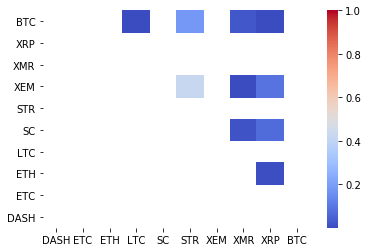

[('DASH', 'LTC'), ('DASH', 'XMR'), ('DASH', 'XRP'), ('LTC', 'XMR'), ('STR', 'XMR'), ('XMR', 'XRP')]


In [10]:
sns.heatmap(pvalues, xticklabels=combined_df.columns, 
                yticklabels=list(reversed(combined_df.columns)), cmap='coolwarm' 
                , mask = (pvalues >= 0.98)
                )
plt.show()
print pairs

In [11]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

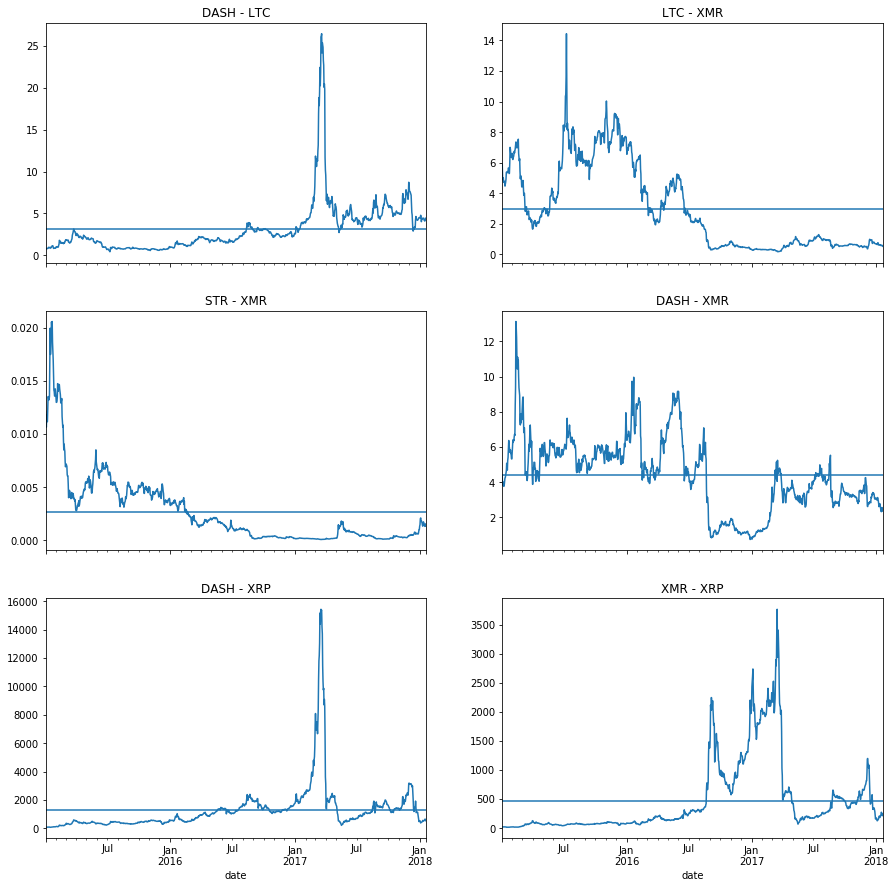

In [12]:
f, axs = plt.subplots(3,2, sharex=True)

for i, pair in  enumerate(pairs):
    S1 =  combined_df[pair[0]]
    S2 =  combined_df[pair[1]]
    score, pvalue, _ = coint(S1, S2)
    ratios = S1 / S2
    ratios.plot(figsize=(15,15), ax=axs[i%3, i%2],title='{} - {}'.format(pair[0], pair[1]))
    axs[i%3, i%2].axhline(ratios.mean())
   

In [102]:
#f, axs = plt.subplots(3,2, sharex=True)

# for i, pair in  enumerate(pairs):
#     S1 =  combined_df[pair[0]]
#     S2 =  combined_df[pair[1]]
#     score, pvalue, _ = coint(S1, S2)
#     ratios = S1 / S2
#     ratios.plot(title='{} - {}'.format(pair[0], pair[1]))
#     plt.axhline(zscore(ratios).mean(), color='black')
#     plt.axhline(1.0, color='red', linestyle='--')
#     plt.axhline(-1.0, color='green', linestyle='--')
#     plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
#     plt.show()
    

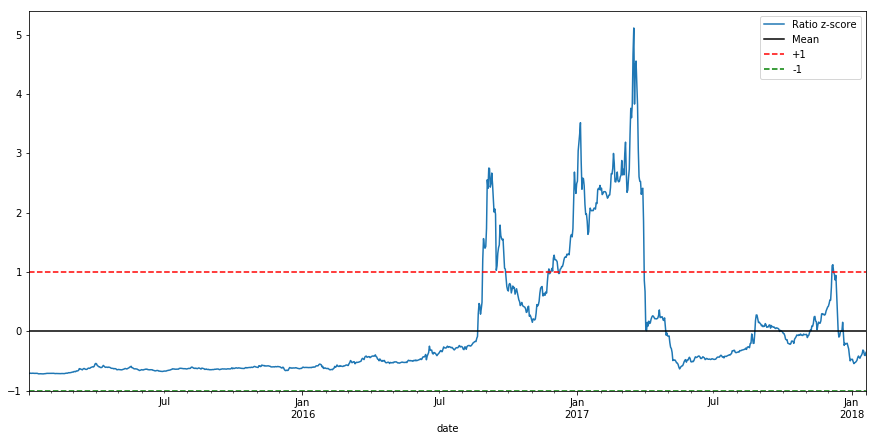

In [13]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
plt.show()

In [12]:
len(ratios)*.7

780.5

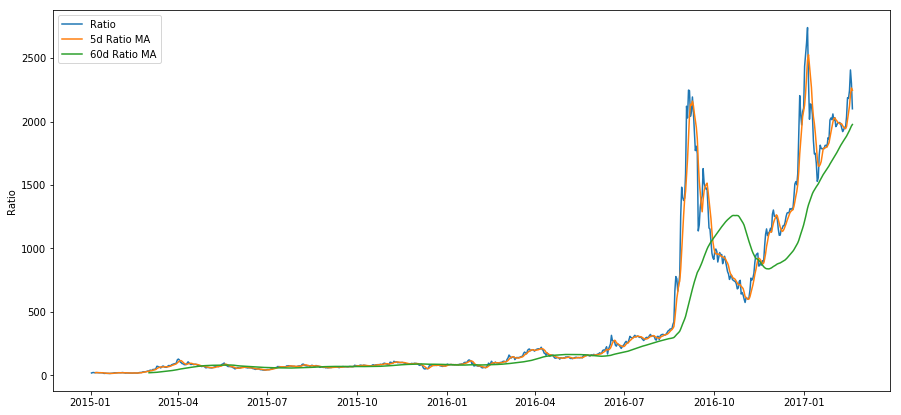

In [14]:
train = ratios[:781]
test= ratios[781:]

ratios_mavg5 = train.rolling(window=5,
                               center=False).mean()

ratios_mavg60 = train.rolling(window=60,
                               center=False).mean()

std_60 = train.rolling(window=60,
                        center=False).std()

zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(15,7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)

plt.legend(['Ratio','5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

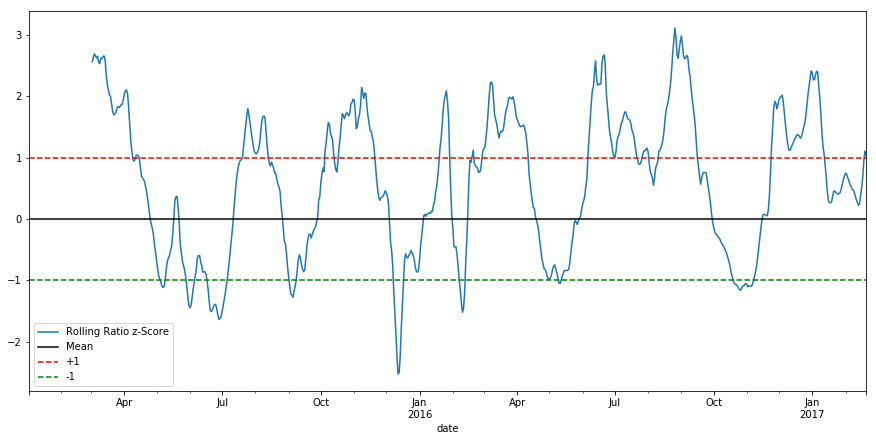

In [14]:
std_60 = train.rolling(window=60,center=False).std()
std_60.name = 'std 60d'

# Compute the z score for each day
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
zscore_60_5.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_60_5.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

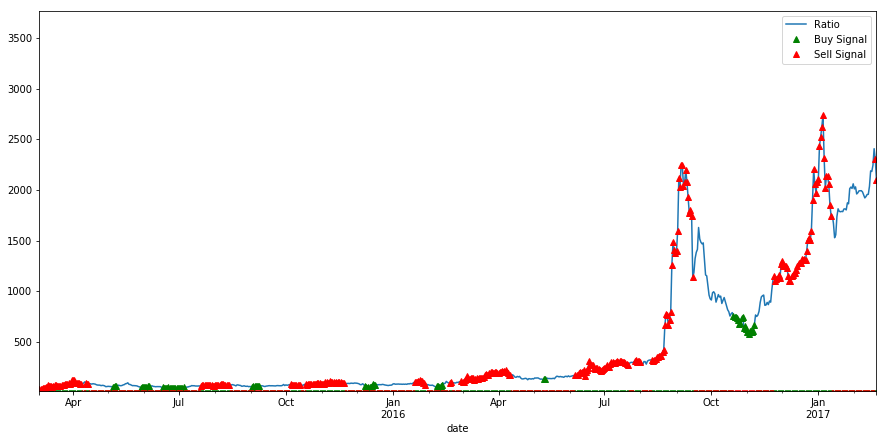

In [15]:
plt.figure(figsize=(15,7))

train[60:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

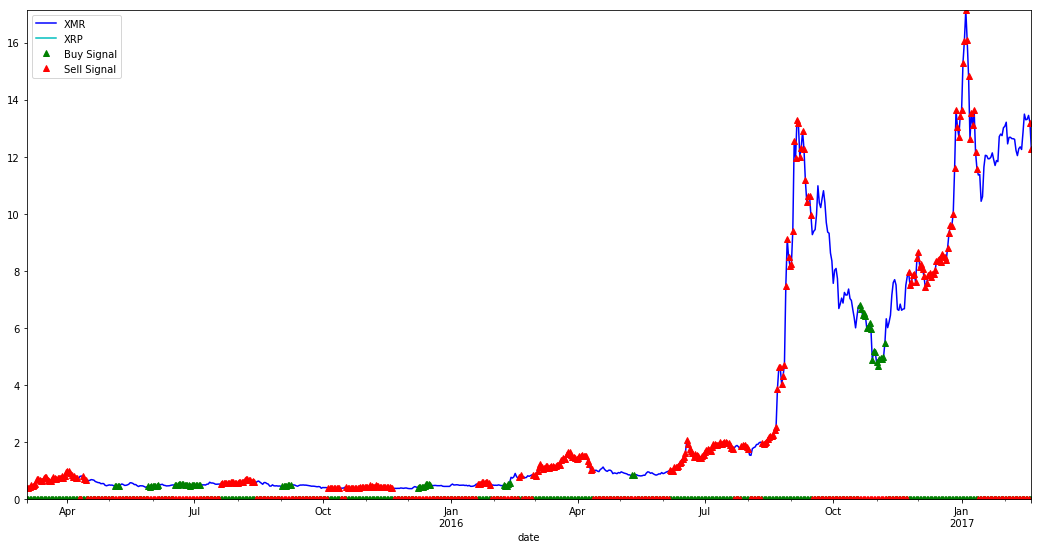

In [16]:
plt.figure(figsize=(18,9))
S1 = combined_df['XMR'].iloc[:781]
S2 = combined_df['XRP'].iloc[:781]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['XMR','XRP', 'Buy Signal', 'Sell Signal'])
plt.show()

In [15]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] > 1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Buy long if the z-score is < 1
        elif zscore[i] < -1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.5:
            money += countS1*S1[i] - S2[i] * countS2
            count = 0
            
    return money

trade(combined_df['XMR'].iloc[:781], combined_df['XRP'].iloc[:781], 60, 5)

11597.653038237277

In [16]:
length_scores = [trade(combined_df['XMR'].iloc[:781], 
                combined_df['XRP'].iloc[:781], l, 5) 
                for l in range(255)]
best_length = np.argmax(length_scores)
print ('Best window length:', best_length)

('Best window length:', 42)


In [17]:
length_scores2 = [trade(combined_df['XMR'].iloc[781:], 
                combined_df['XRP'].iloc[781:], l, 5) 
                for l in range(255)]
print (best_length, 'day window:', length_scores2[best_length])

# Find the best window length based on this dataset, 
# and the returns using this window length
best_length2 = np.argmax(length_scores2)
print (best_length2, 'day window:', length_scores2[best_length2])

(42, 'day window:', 604.63258572152699)
(168, 'day window:', 531074.4476087509)


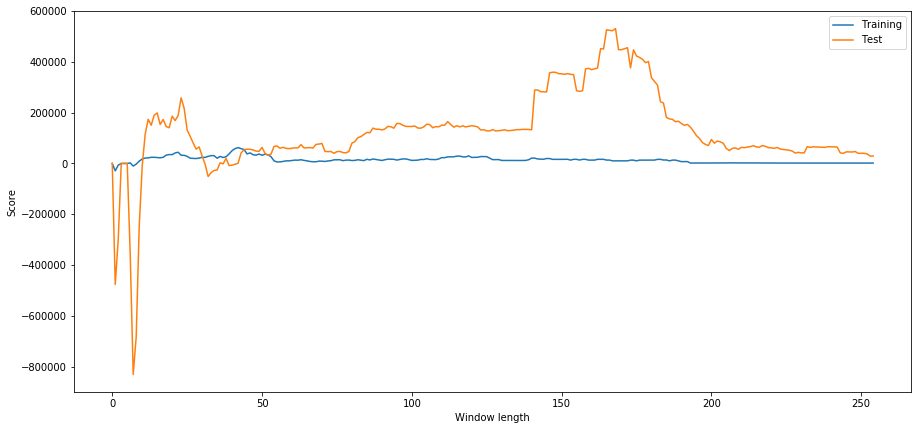

In [18]:
plt.figure(figsize=(15,7))
plt.plot(length_scores)
plt.plot(length_scores2)
plt.xlabel('Window length')
plt.ylabel('Score')
plt.legend(['Training', 'Test'])
plt.show()

Credits
-------

https://github.com/Auquan/Tutorials/blob/master/Pairs%20Trading.ipynb